In [ ]:
PUMP_LEVELS = [0, 200, 466, 733, 999]
VALVE_LEVELS = [0, 10, 40, 70, 100]
log_dir = "u01"

# PUMP_LEVELS = [0, 200, 400, 700, 999]
# VALVE_LEVELS = [0, 10, 20, 50, 100]
# log_dir = "u02"

In [23]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


def map_to_index(value, levels):
    """Map a numeric value to its closest index in a known level list."""
    return min(range(len(levels)), key=lambda i: abs(value - levels[i]))

def load_delivered_trials(trials_json_path):
    with open(trials_json_path, 'r') as f:
        trials = json.load(f)
    # Build a dict: trial_number → (vibration_delivered, pressure_delivered)
    return {
        trial["trial_number"]: (trial["vibration_delivered"], trial["pressure_delivered"])
        for trial in trials
    }

def load_selected_response(log_file_path):
    with open(log_file_path, 'r') as f:
        data = json.load(f)
    if not data:
        return None
    last_entry = data[-1]
    pump_val = last_entry.get("pump", 0)
    valve_val = last_entry.get("valve", 0)
    pressure_selected = map_to_index(pump_val, PUMP_LEVELS)
    vibration_selected = map_to_index(valve_val, VALVE_LEVELS)
    return pressure_selected, vibration_selected

def parse_all_trials(log_dir, trials_json_path):
    delivered = load_delivered_trials(trials_json_path)
    results = []

    for filename in sorted(os.listdir(log_dir)):
        if filename.endswith("_log.json") and "training" not in filename:
            try:
                trial_num = int(filename.split("_trial")[1].split("_")[0])
                log_path = os.path.join(log_dir, filename)
                selected = load_selected_response(log_path)
                if selected:
                    pressure_selected, vibration_selected = selected
                    vibration_delivered, pressure_delivered = delivered[trial_num]
                    results.append({
                        "trial": trial_num,
                        "vibration_delivered": vibration_delivered,
                        "pressure_delivered": pressure_delivered,
                        "vibration_selected": vibration_selected,
                        "pressure_selected": pressure_selected
                    })
            except Exception as e:
                print(f"⚠️ Skipping {filename}: {e}")
    return results

# === Run ===
trials_json_path = f"App Trials/generated_trials/{log_dir}_trials.json"

parsed_results = parse_all_trials(log_dir, trials_json_path)

# Optional: Print or save
for entry in parsed_results:
    print(entry)

{'trial': 10, 'vibration_delivered': 0, 'pressure_delivered': 3, 'vibration_selected': 0, 'pressure_selected': 3}
{'trial': 11, 'vibration_delivered': 2, 'pressure_delivered': 2, 'vibration_selected': 3, 'pressure_selected': 2}
{'trial': 12, 'vibration_delivered': 1, 'pressure_delivered': 1, 'vibration_selected': 1, 'pressure_selected': 1}
{'trial': 13, 'vibration_delivered': 2, 'pressure_delivered': 1, 'vibration_selected': 2, 'pressure_selected': 1}
{'trial': 14, 'vibration_delivered': 1, 'pressure_delivered': 2, 'vibration_selected': 1, 'pressure_selected': 2}
{'trial': 15, 'vibration_delivered': 3, 'pressure_delivered': 4, 'vibration_selected': 4, 'pressure_selected': 2}
{'trial': 16, 'vibration_delivered': 1, 'pressure_delivered': 3, 'vibration_selected': 1, 'pressure_selected': 2}
{'trial': 17, 'vibration_delivered': 4, 'pressure_delivered': 3, 'vibration_selected': 3, 'pressure_selected': 1}
{'trial': 18, 'vibration_delivered': 0, 'pressure_delivered': 4, 'vibration_selected': 0

In [24]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def build_confusion_matrix(results, normalize=False):
    """
    Build a 2D confusion matrix with multi-index rows and columns:
    (vibration_delivered, pressure_delivered) → (vibration_selected, pressure_selected)
    """
    # Build flat count matrix
    matrix = {}

    for r in results:
        key = (r["vibration_delivered"], r["pressure_delivered"])
        val = (r["vibration_selected"], r["pressure_selected"])
        matrix[(key, val)] = matrix.get((key, val), 0) + 1

    # Convert to full DataFrame
    all_labels = [(v, p) for v in range(5) for p in range(1, 5)]
    df = pd.DataFrame(
        0, index=pd.MultiIndex.from_tuples(all_labels, names=["V_Del", "P_Del"]),
        columns=pd.MultiIndex.from_tuples(all_labels, names=["V_Sel", "P_Sel"])
    )

    for (delivered, selected), count in matrix.items():
        df.loc[delivered, selected] = count

    if normalize:
        df = df.div(df.sum(axis=1), axis=0).fillna(0)

    return df

def plot_confusion_matrix(conf_matrix, title="Confusion Matrix", cmap="Blues"):
    """Display a heatmap from a 2D MultiIndex confusion matrix"""
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt=".0f" if conf_matrix.values.max() > 1 else ".2f",
                cmap=cmap, cbar=True)
    plt.title(title)
    plt.xlabel("Perceived (Vibration, Pressure)")
    plt.ylabel("Delivered (Vibration, Pressure)")
    plt.tight_layout()
    plt.show()

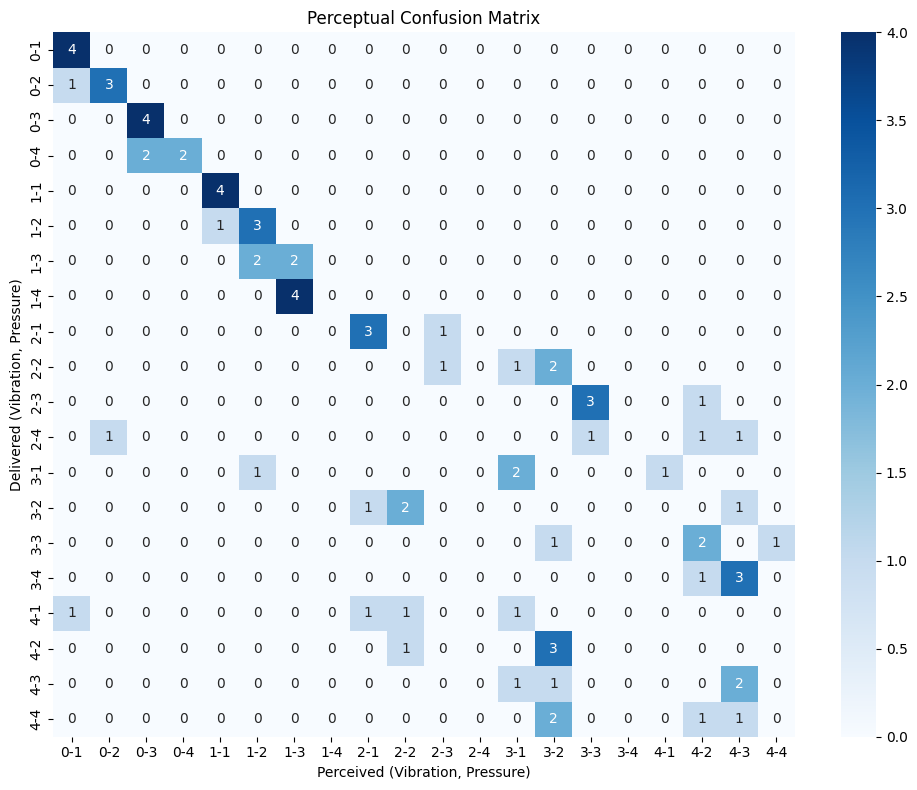

In [25]:
# Assuming `parsed_results` from earlier
conf_mat = build_confusion_matrix(parsed_results, normalize=False)  # or True
plot_confusion_matrix(conf_mat, title="Perceptual Confusion Matrix")

In [26]:

def build_vibration_confusion(results, normalize=False):
    matrix = pd.DataFrame(0, index=range(5), columns=range(5))  # 0–4
    for r in results:
        v_d = r["vibration_delivered"]
        v_s = r["vibration_selected"]
        matrix.loc[v_d, v_s] += 1
    if normalize:
        matrix = matrix.div(matrix.sum(axis=1), axis=0).fillna(0)
    return matrix

def build_pressure_confusion(results, normalize=False):
    matrix = pd.DataFrame(0, index=range(1, 5), columns=range(1, 5))  # 1–4
    for r in results:
        p_d = r["pressure_delivered"]
        p_s = r["pressure_selected"]
        matrix.loc[p_d, p_s] += 1
    if normalize:
        matrix = matrix.div(matrix.sum(axis=1), axis=0).fillna(0)
    return matrix

def plot_confusion(matrix, title, xlabel, ylabel, cmap="Blues"):
    plt.figure(figsize=(6, 5))
    sns.heatmap(matrix, annot=True, fmt=".0f" if matrix.values.max() > 1 else ".2f", cmap=cmap)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.tight_layout()
    plt.show()

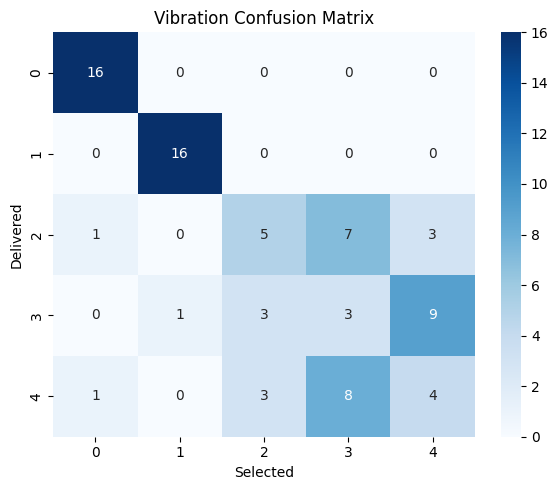

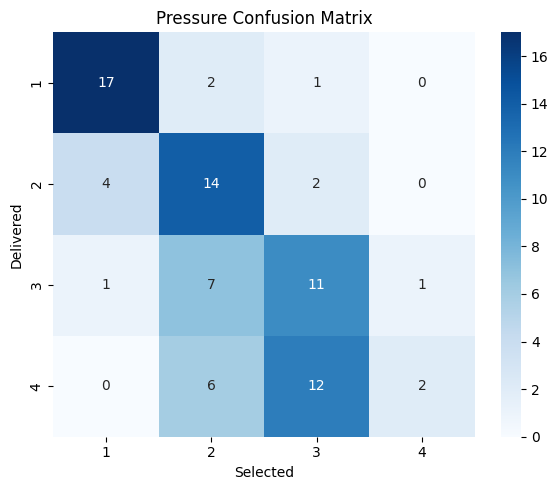

In [27]:
vib_matrix = build_vibration_confusion(parsed_results, normalize=False)
pres_matrix = build_pressure_confusion(parsed_results, normalize=False)

plot_confusion(vib_matrix, "Vibration Confusion Matrix", "Selected", "Delivered")
plot_confusion(pres_matrix, "Pressure Confusion Matrix", "Selected", "Delivered")

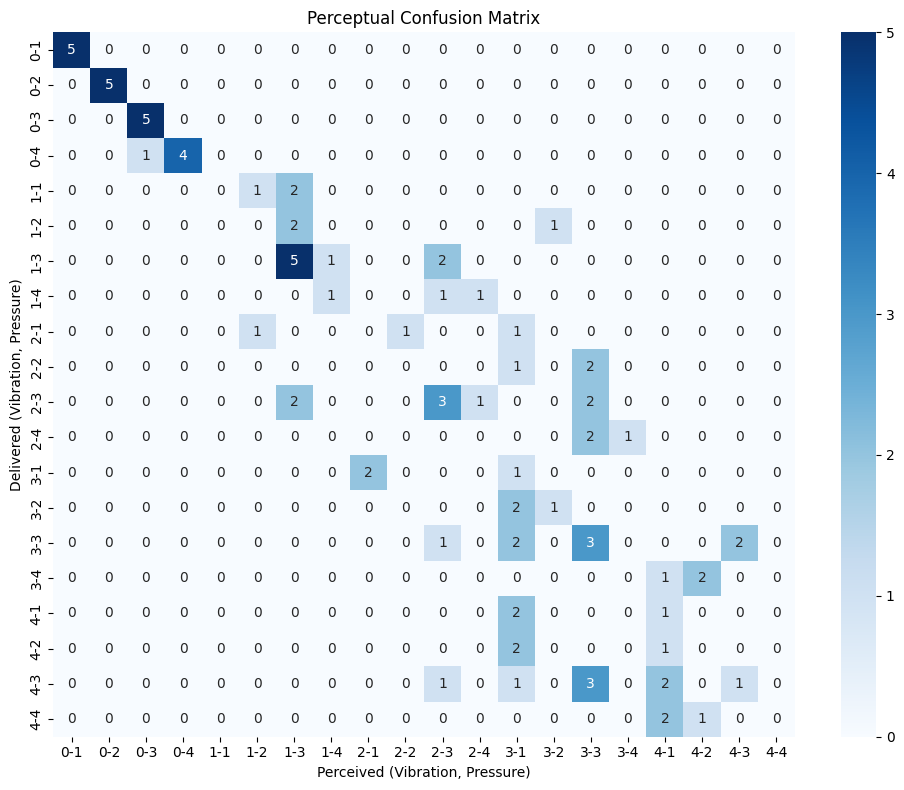

In [10]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

VALVE_LEVELS = [0, 10, 20, 50, 100]
PUMP_LEVELS = [0, 200, 400, 700, 999]

def map_to_index(value, levels):
    return min(range(len(levels)), key=lambda i: abs(value - levels[i]))

def load_delivered_trials(trials_json_path):
    with open(trials_json_path, 'r') as f:
        trials = json.load(f)
    return {
        trial["trial_number"]: (trial["vibration_level"], trial["pressure_level"])
        for trial in trials
    }

def load_selected_response(log_file_path):
    with open(log_file_path, 'r') as f:
        data = json.load(f)
    if not data:
        return None
    last_entry = data[-1]
    pump_val = last_entry.get("pump", 0)
    valve_val = last_entry.get("valve", 0)
    pressure_selected = map_to_index(pump_val, PUMP_LEVELS)
    vibration_selected = map_to_index(valve_val, VALVE_LEVELS)
    return pressure_selected, vibration_selected

def parse_all_trials(log_dir, trials_json_path):
    delivered = load_delivered_trials(trials_json_path)
    results = []

    for filename in sorted(os.listdir(log_dir)):
        if filename.endswith("_log.json") and "training" not in filename:
            try:
                trial_num = int(filename.split("_trial")[1].split("_")[0])
                log_path = os.path.join(log_dir, filename)
                selected = load_selected_response(log_path)
                if selected:
                    pressure_selected, vibration_selected = selected

                    # Clamp perceived pressure to minimum index 1
                    if pressure_selected == 0:
                        pressure_selected = 1

                    vibration_delivered, pressure_delivered = delivered[trial_num]
                    results.append({
                        "trial": trial_num,
                        "vibration_delivered": vibration_delivered,
                        "pressure_delivered": pressure_delivered,
                        "vibration_selected": vibration_selected,
                        "pressure_selected": pressure_selected
                    })
            except Exception as e:
                print(f"⚠️ Skipping {filename}: {e}")
    return results

def build_confusion_matrix(results, normalize=False):
    matrix = {}
    for r in results:
        key = (r["vibration_delivered"], r["pressure_delivered"])
        val = (r["vibration_selected"], r["pressure_selected"])
        matrix[(key, val)] = matrix.get((key, val), 0) + 1

    all_labels = [(v, p) for v in range(5) for p in range(1, 5)]
    df = pd.DataFrame(
        0, index=pd.MultiIndex.from_tuples(all_labels, names=["V_Del", "P_Del"]),
        columns=pd.MultiIndex.from_tuples(all_labels, names=["V_Sel", "P_Sel"])
    )

    for (delivered, selected), count in matrix.items():
        df.loc[delivered, selected] = count

    if normalize:
        df = df.div(df.sum(axis=1), axis=0).fillna(0)

    return df

def plot_confusion_matrix(conf_matrix, title="Confusion Matrix", cmap="Blues"):
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt=".0f" if conf_matrix.values.max() > 1 else ".2f",
                cmap=cmap, cbar=True)
    plt.title(title)
    plt.xlabel("Perceived (Vibration, Pressure)")
    plt.ylabel("Delivered (Vibration, Pressure)")
    plt.tight_layout()
    plt.show()

# === Run ===

PARTICIPANT = "U03"  # Change this to the participant ID you want to analyze

# Find the folder in the current directory that contains "U13" in its name
log_dir = next(folder for folder in os.listdir() if PARTICIPANT in folder)
trials_json_path = f"App Trials/3exp_trials_counterbalanced/{PARTICIPANT}_trials.json"
parsed_results = parse_all_trials(log_dir, trials_json_path)

conf_mat = build_confusion_matrix(parsed_results, normalize=False)
plot_confusion_matrix(conf_mat, title="Perceptual Confusion Matrix")

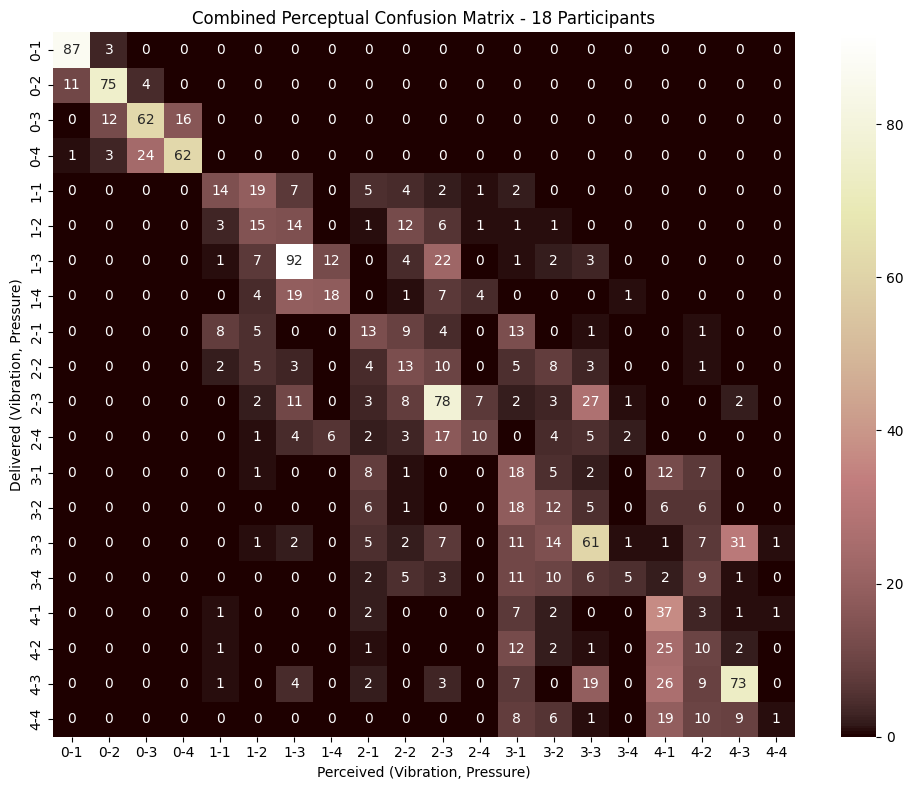

In [26]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

VALVE_LEVELS = [0, 10, 20, 50, 100]
PUMP_LEVELS = [0, 200, 400, 700, 999]

manipulate_count = 0  # Initialize manipulate count

def map_to_index(value, levels):
    return min(range(len(levels)), key=lambda i: abs(value - levels[i]))

def load_delivered_trials(trials_json_path):
    with open(trials_json_path, 'r') as f:
        trials = json.load(f)
    return {
        trial["trial_number"]: (trial["vibration_level"], trial["pressure_level"])
        for trial in trials
    }

def load_selected_response(log_file_path):
    with open(log_file_path, 'r') as f:
        data = json.load(f)
    if not data:
        return None
    last_entry = data[-1]
    pump_val = last_entry.get("pump", 0)
    valve_val = last_entry.get("valve", 0)
    pressure_selected = map_to_index(pump_val, PUMP_LEVELS)
    vibration_selected = map_to_index(valve_val, VALVE_LEVELS)
    return pressure_selected, vibration_selected

def parse_all_trials(log_dir, trials_json_path, manipulate_count):
    delivered = load_delivered_trials(trials_json_path)
    results = []

    for filename in sorted(os.listdir(log_dir)):
        if filename.endswith("_log.json") and "training" not in filename:
            try:
                trial_num = int(filename.split("_trial")[1].split("_")[0])
                log_path = os.path.join(log_dir, filename)
                selected = load_selected_response(log_path)
                if selected:
                    pressure_selected, vibration_selected = selected

                    # Clamp perceived pressure to minimum index 1
                    if pressure_selected == 0:
                        pressure_selected = 1
                        manipulate_count += 1

                    vibration_delivered, pressure_delivered = delivered[trial_num]
                    results.append({
                        "trial": trial_num,
                        "vibration_delivered": vibration_delivered,
                        "pressure_delivered": pressure_delivered,
                        "vibration_selected": vibration_selected,
                        "pressure_selected": pressure_selected
                    })
            except Exception as e:
                print(f"⚠️ Skipping {filename}: {e}")
    return results

def build_confusion_matrix(results, normalize=False):
    matrix = {}
    for r in results:
        key = (r["vibration_delivered"], r["pressure_delivered"])
        val = (r["vibration_selected"], r["pressure_selected"])
        matrix[(key, val)] = matrix.get((key, val), 0) + 1

    all_labels = [(v, p) for v in range(5) for p in range(1, 5)]
    df = pd.DataFrame(
        0, index=pd.MultiIndex.from_tuples(all_labels, names=["V_Del", "P_Del"]),
        columns=pd.MultiIndex.from_tuples(all_labels, names=["V_Sel", "P_Sel"])
    )

    for (delivered, selected), count in matrix.items():
        df.loc[delivered, selected] += count

    if normalize:
        df = df.div(df.sum(axis=1), axis=0).fillna(0)

    return df

def plot_confusion_matrix(conf_matrix, title="Combined Confusion Matrix", cmap="pink"):
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt=".0f" if conf_matrix.values.max() > 1 else ".2f",
                cmap=cmap, cbar=True)
    plt.title(title)
    plt.xlabel("Perceived (Vibration, Pressure)")
    plt.ylabel("Delivered (Vibration, Pressure)")
    plt.tight_layout()
    plt.show()

# === Run for all participants ===

NUMBER_OF_PARTICIPANTS = 18
base_trial_path = "App Trials/3exp_trials_counterbalanced"
all_results = []

for i in range(1, NUMBER_OF_PARTICIPANTS + 1):
    user_id = f"U{str(i).zfill(2)}"
    try:
        log_dir = next(folder for folder in os.listdir() if user_id in folder)
        trials_json_path = os.path.join(base_trial_path, f"{user_id}_trials.json")
        user_results = parse_all_trials(log_dir, trials_json_path, manipulate_count)
        all_results.extend(user_results)
    except Exception as e:
        print(f"⚠️ Skipping {user_id}: {e}")

conf_mat = build_confusion_matrix(all_results, normalize=False)
plot_confusion_matrix(conf_mat, title=f"Combined Perceptual Confusion Matrix - {NUMBER_OF_PARTICIPANTS} Participants")

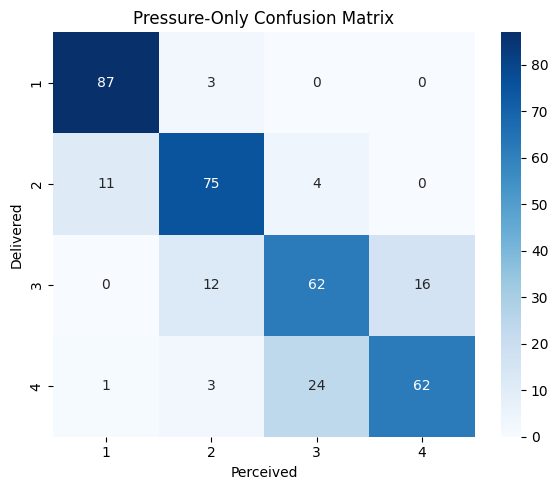

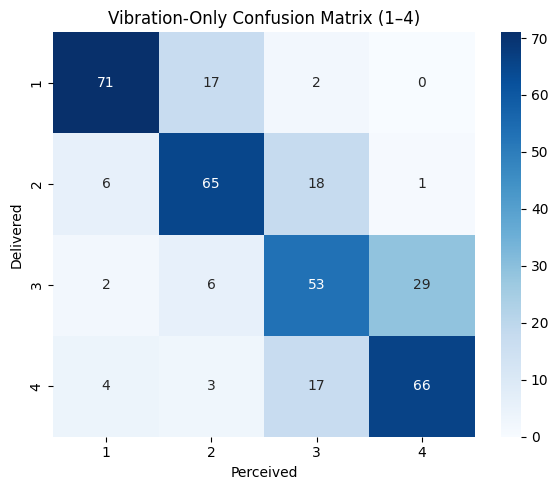

In [28]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

VALVE_LEVELS = [0, 10, 20, 50, 100]
PUMP_LEVELS = [0, 200, 400, 700, 999]

def map_to_index(value, levels):
    return min(range(len(levels)), key=lambda i: abs(value - levels[i]))

def load_delivered_trials(trials_json_path):
    with open(trials_json_path, 'r') as f:
        trials = json.load(f)
    return {
        trial["trial_number"]: {
            "vibration": trial["vibration_level"],
            "pressure": trial["pressure_level"],
            "trial_type": trial["trial_type"]
        }
        for trial in trials
    }

def load_selected_response(log_file_path):
    with open(log_file_path, 'r') as f:
        data = json.load(f)
    if not data:
        return None
    last_entry = data[-1]
    pump_val = last_entry.get("pump", 0)
    valve_val = last_entry.get("valve", 0)
    pressure_selected = map_to_index(pump_val, PUMP_LEVELS)
    vibration_selected = map_to_index(valve_val, VALVE_LEVELS)
    return pressure_selected, vibration_selected

def parse_trials_by_type(log_dir, trials_json_path, target_type):
    delivered = load_delivered_trials(trials_json_path)
    results = []

    for filename in sorted(os.listdir(log_dir)):
        if filename.endswith("_log.json") and "training" not in filename:
            try:
                trial_num = int(filename.split("_trial")[1].split("_")[0])
                log_path = os.path.join(log_dir, filename)
                if delivered[trial_num]["trial_type"] != target_type:
                    continue

                selected = load_selected_response(log_path)
                if selected:
                    pressure_selected, vibration_selected = selected

                    # Clamp perceived pressure to minimum index 1
                    if pressure_selected == 0:
                        pressure_selected = 1

                    results.append({
                        "trial": trial_num,
                        "trial_type": target_type,
                        "vibration_delivered": delivered[trial_num]["vibration"],
                        "pressure_delivered": delivered[trial_num]["pressure"],
                        "vibration_selected": vibration_selected,
                        "pressure_selected": pressure_selected
                    })
            except Exception as e:
                print(f"⚠️ Skipping {filename}: {e}")
    return results

def build_confusion_matrix(results, feedback_mode, normalize=False):
    if feedback_mode == "pressure":
        labels = list(range(1, 5))
        index_col = "pressure_delivered"
        selected_col = "pressure_selected"
    elif feedback_mode == "vibration":
        labels = list(range(1, 5))  # EXCLUDES 0
        index_col = "vibration_delivered"
        selected_col = "vibration_selected"
    else:
        raise ValueError("Invalid feedback_mode. Use 'pressure' or 'vibration'.")

    df = pd.DataFrame(0, index=labels, columns=labels)

    for r in results:
        i = r[index_col]
        j = r[selected_col]

        # Skip if vibration level is 0 in vibration mode
        if feedback_mode == "vibration" and (i == 0 or j == 0):
            continue

        df.loc[i, j] += 1

    if normalize:
        df = df.div(df.sum(axis=1), axis=0).fillna(0)

    return df

def plot_confusion_matrix(conf_matrix, title="Confusion Matrix", cmap="Blues"):
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt=".0f" if conf_matrix.values.max() > 1 else ".2f",
                cmap=cmap, cbar=True)
    plt.title(title)
    plt.xlabel("Perceived")
    plt.ylabel("Delivered")
    plt.tight_layout()
    plt.show()

# === Run for all participants ===

NUMBER_OF_PARTICIPANTS = 18
base_trial_path = "App Trials/3exp_trials_counterbalanced"
pressure_results = []
vibration_results = []

for i in range(1, NUMBER_OF_PARTICIPANTS + 1):
    user_id = f"U{str(i).zfill(2)}"
    try:
        log_dir = next(folder for folder in os.listdir() if user_id in folder)
        trials_json_path = os.path.join(base_trial_path, f"{user_id}_trials.json")

        pressure_results.extend(parse_trials_by_type(log_dir, trials_json_path, target_type="pressure"))
        vibration_results.extend(parse_trials_by_type(log_dir, trials_json_path, target_type="vibration"))
    except Exception as e:
        print(f"⚠️ Skipping {user_id}: {e}")

# === Plot ===
pressure_conf = build_confusion_matrix(pressure_results, feedback_mode="pressure", normalize=False)
plot_confusion_matrix(pressure_conf, title="Pressure-Only Confusion Matrix")

vibration_conf = build_confusion_matrix(vibration_results, feedback_mode="vibration", normalize=False)
plot_confusion_matrix(vibration_conf, title="Vibration-Only Confusion Matrix (1–4)")